# Data Loading
1) CIFAR-10/100 Corrupted

2) ImageNet-C

3) ImageNet-R

In [1]:
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR-10 (auto-downloads if not present)
cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_loader = DataLoader(cifar10, batch_size=64, shuffle=False)

# CIFAR-100
cifar100 = CIFAR100(root='./data', train=False, download=True, transform=transform)
cifar100_loader = DataLoader(cifar100, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 49.5MB/s]
100%|██████████| 169M/169M [00:03<00:00, 49.2MB/s]


In [2]:
from torch.utils.data import random_split

# Split CIFAR-10: 90% for "test-time adaptation", 10% as "true test" set
lengths = [int(0.9 * len(cifar10)), len(cifar10) - int(0.9 * len(cifar10))]
cifar10_adapt, cifar10_test = random_split(cifar10, lengths)

# Same for CIFAR-100
lengths = [int(0.9 * len(cifar100)), len(cifar100) - int(0.9 * len(cifar100))]
cifar100_adapt, cifar100_test = random_split(cifar100, lengths)

# DataLoaders
adapt_loader = DataLoader(cifar10_adapt, batch_size=64, shuffle=False)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)


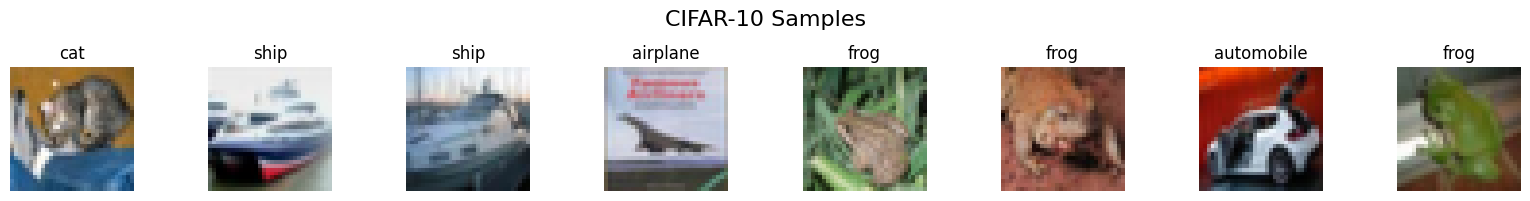

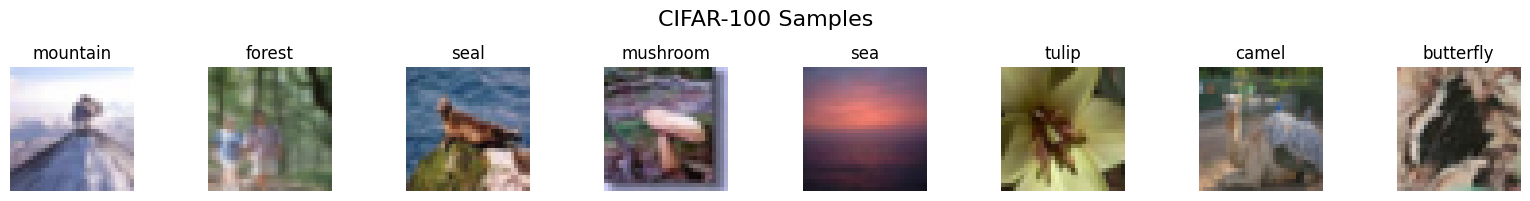

In [3]:
import matplotlib.pyplot as plt
# Unnormalize function
def unnormalize(img):
    return img * 0.5 + 0.5  # reverse normalization (0.5, 0.5)

# Plot helper
def show_images(loader, classes, title):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    images = unnormalize(images)

    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    fig.suptitle(title, fontsize=16)
    for i in range(8):
        img = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Class names
cifar10_classes = cifar10.classes
cifar100_classes = cifar100.classes

# Show CIFAR-10 and CIFAR-100 samples
show_images(cifar10_loader, cifar10_classes, "CIFAR-10 Samples")
show_images(cifar100_loader, cifar100_classes, "CIFAR-100 Samples")

# CIBAR10/100 C

In [4]:
# Step 1: Install gdown if not already installed
!pip install -q gdown

# Step 2: Download CIFAR-10-C (132MB)
import gdown
gdown.download("https://zenodo.org/record/2535967/files/CIFAR-10-C.tar", output="CIFAR-10-C.tar", quiet=False)

# Step 3: Extract the .tar file
import tarfile
with tarfile.open("CIFAR-10-C.tar", "r") as tar:
    tar.extractall("CIFAR-10-C")


Downloading...
From: https://zenodo.org/record/2535967/files/CIFAR-10-C.tar
To: /content/CIFAR-10-C.tar
100%|██████████| 2.92G/2.92G [02:19<00:00, 20.9MB/s]


In [41]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# --------------------- Config ---------------------
corruption_type = 'gaussian_noise'  # e.g., 'gaussian_noise', 'motion_blur', etc.
severity = 1                         # Severity level: 1 to 5
root_dir = '/content/CIFAR-10-C/CIFAR-10-C'  # Path to CIFAR-10-C data

# --------------------- Load Corrupted Images ---------------------
corruption_path = os.path.join(root_dir, f'{corruption_type}.npy')
labels_path = os.path.join(root_dir, 'labels.npy')

images = np.load(corruption_path)     # Shape: (50000, 32, 32, 3)
labels = np.load(labels_path)         # Shape: (50000,)

# --------------------- Subset by Severity ---------------------
# Each severity level has 10,000 samples
start = (severity - 1) * 10000
end = severity * 10000
images = images[start:end]            # Shape: (10000, 32, 32, 3)
labels = labels[start:end]            # Shape: (10000,)

# --------------------- Transform to Tensor ---------------------
# Normalization values for CIFAR-10: (mean, std) per channel
normalize = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                 std=(0.2023, 0.1994, 0.2010))

transform = transforms.Compose([
    transforms.ToTensor(),    # Converts HWC [0,255] to CHW [0.0,1.0]
    normalize
])

# Apply transform manually since we start from numpy
processed_images = torch.stack([transform(img) for img in images])  # (10000, 3, 32, 32)
labels_10c = torch.tensor(labels, dtype=torch.long)                 # (10000,)

# --------------------- Dataset & DataLoader ---------------------
dataset_10c = TensorDataset(processed_images, labels_10c)
dataloader10 = DataLoader(dataset_10c, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Loaded {len(dataset_10c)} samples from CIFAR-10-C [{corruption_type}, severity={severity}]")


✅ Loaded 10000 samples from CIFAR-10-C [gaussian_noise, severity=1]


In [6]:
# Step 1: Install gdown
!pip install -q gdown

# Step 2: Download CIFAR-100-C (217MB)
import gdown
gdown.download("https://zenodo.org/record/3555552/files/CIFAR-100-C.tar", output="CIFAR-100-C.tar", quiet=False)

# Step 3: Extract the .tar file
import tarfile
with tarfile.open("CIFAR-100-C.tar", "r") as tar:
    tar.extractall("CIFAR-100-C")



Downloading...
From: https://zenodo.org/record/3555552/files/CIFAR-100-C.tar
To: /content/CIFAR-100-C.tar
100%|██████████| 2.92G/2.92G [02:20<00:00, 20.7MB/s]


In [42]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# --------------------- Config ---------------------
corruption_type = 'gaussian_noise'  # e.g., 'gaussian_noise', 'motion_blur', etc.
severity = 1                         # Severity level: 1 to 5
root_dir = '/content/CIFAR-100-C/CIFAR-100-C'  # Path to CIFAR-100-C data

# --------------------- Load Corrupted Images ---------------------
corruption_path = os.path.join(root_dir, f'{corruption_type}.npy')
labels_path = os.path.join(root_dir, 'labels.npy')

images = np.load(corruption_path)     # Shape: (50000, 32, 32, 3)
labels = np.load(labels_path)         # Shape: (50000,)

# --------------------- Subset by Severity ---------------------
start = (severity - 1) * 10000
end = severity * 10000
images = images[start:end]            # Shape: (10000, 32, 32, 3)
labels = labels[start:end]            # Shape: (10000,)

# --------------------- Transform to Tensor ---------------------
# Normalization values for CIFAR-100 (same as CIFAR-10)
normalize = transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                                 std=(0.2675, 0.2565, 0.2761))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# Apply transform manually
processed_images = torch.stack([transform(img) for img in images])  # (10000, 3, 32, 32)
labels_100c = torch.tensor(labels, dtype=torch.long)                # (10000,)

# --------------------- Dataset & DataLoader ---------------------
dataset_100c = TensorDataset(processed_images, labels_100c)
dataloader100 = DataLoader(dataset_100c, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Loaded {len(dataset_100c)} samples from CIFAR-100-C [{corruption_type}, severity={severity}]")


✅ Loaded 10000 samples from CIFAR-100-C [gaussian_noise, severity=1]


# Model Loading - ResNet26 for CIFAR10-C and CIFAR100-C

In [11]:
import timm
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('resnet26.bt_in1k', pretrained=True, num_classes=10)
model = model.to(device)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm

# -------------------- 1. Device Setup --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- 2. Data Transforms --------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# -------------------- 3. Dataset & Dataloaders --------------------
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


# -------------------- 5. Loss, Optimizer, Scheduler --------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# -------------------- 6. Training Function --------------------
def train(model, loader):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    print(f"Train Loss: {running_loss/len(loader):.4f}, Accuracy: {acc:.2f}%")

# -------------------- 7. Evaluation Function --------------------
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

# -------------------- 8. Training Loop --------------------
for epoch in range(1, 11):
    print(f"\nEpoch {epoch}")
    train(model, train_loader)
    evaluate(model, test_loader)
    scheduler.step()

# -------------------- 9. Save Model --------------------
torch.save(model.state_dict(), 'resnet26_cifar10.pth')



Epoch 1
Train Loss: 0.6749, Accuracy: 78.14%
Test Accuracy: 80.42%

Epoch 2
Train Loss: 0.6753, Accuracy: 78.13%
Test Accuracy: 80.61%

Epoch 3
Train Loss: 0.5777, Accuracy: 80.76%
Test Accuracy: 81.53%

Epoch 4
Train Loss: 0.5180, Accuracy: 82.72%
Test Accuracy: 82.17%

Epoch 5
Train Loss: 0.4963, Accuracy: 83.21%
Test Accuracy: 83.27%

Epoch 6
Train Loss: 0.4782, Accuracy: 83.96%
Test Accuracy: 82.76%

Epoch 7
Train Loss: 0.5402, Accuracy: 82.31%
Test Accuracy: 79.69%

Epoch 8
Train Loss: 0.4791, Accuracy: 83.80%
Test Accuracy: 83.28%

Epoch 9
Train Loss: 0.4477, Accuracy: 84.97%
Test Accuracy: 77.25%

Epoch 10
Train Loss: 0.4512, Accuracy: 84.61%
Test Accuracy: 84.97%


In [14]:
import torch
import torch.nn.functional as F

def get_preds_and_labels(model, dataloader):
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.cuda()
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs.cpu())
            all_labels.append(y)
    return torch.cat(all_probs), torch.cat(all_labels)


In [15]:
def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

def nll_loss(probs, labels):
    return F.nll_loss(probs.log(), labels).item()

def brier_score(probs, labels, num_classes=10):
    labels = labels.long()  # Ensure correct type
    one_hot = F.one_hot(labels, num_classes=num_classes).float()
    return ((probs - one_hot) ** 2).sum(dim=1).mean().item()


def ece(probs, labels, n_bins=15):
    confidences, predictions = probs.max(dim=1)
    accuracies = predictions.eq(labels)
    ece = torch.zeros(1)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    for i in range(n_bins):
        in_bin = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin > 0:
            acc_in_bin = accuracies[in_bin].float().mean()
            avg_conf = confidences[in_bin].mean()
            ece += torch.abs(avg_conf - acc_in_bin) * prop_in_bin
    return ece.item()


In [16]:
probs, labels = get_preds_and_labels(model, dataloader10)

acc = accuracy(probs, labels)
nll = nll_loss(probs, labels)
brier = brier_score(probs, labels)
ece_val = ece(probs, labels)

print(f"Accuracy: {acc:.4f}")
print(f"NLL: {nll:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ECE: {ece_val:.4f}")


Accuracy: 0.5633
NLL: 1.4737
Brier Score: 0.6271
ECE: 0.2082


In [25]:
import timm
import torch.nn as nn

# Create the model with the correct number of classes
model1 = timm.create_model('resnet26.bt_in1k', pretrained=True, num_classes=100)

# (Optional) You can also reset classifier explicitly if needed
# model1.reset_classifier(num_classes=100)

# Move to GPU if available

model1 = model1.to(device)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm

# -------------------- 1. Device Setup --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- 2. Data Transforms --------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2762))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2762))
])

# -------------------- 3. Dataset & Dataloaders --------------------
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)



# -------------------- 5. Loss, Optimizer, Scheduler --------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# -------------------- 6. Training Function --------------------
def train(model1, loader):
    model1.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    print(f"Train Loss: {running_loss/len(loader):.4f}, Accuracy: {acc:.2f}%")

# -------------------- 7. Evaluation Function --------------------
def evaluate(model1, loader):
    model1.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

# -------------------- 8. Training Loop --------------------
for epoch in range(1, 11):
    print(f"\nEpoch {epoch}")
    train(model1, train_loader)
    evaluate(model1, test_loader)
    scheduler.step()

# -------------------- 9. Save Model --------------------
torch.save(model1.state_dict(), 'resnet26_cifar100.pth')



Epoch 1
Train Loss: 1.9390, Accuracy: 47.40%
Test Accuracy: 48.48%

Epoch 2
Train Loss: 1.8301, Accuracy: 50.00%
Test Accuracy: 49.91%

Epoch 3
Train Loss: 1.7427, Accuracy: 51.83%
Test Accuracy: 50.24%

Epoch 4
Train Loss: 1.6515, Accuracy: 53.78%
Test Accuracy: 50.50%

Epoch 5
Train Loss: 1.5923, Accuracy: 55.41%
Test Accuracy: 53.23%

Epoch 6
Train Loss: 1.5245, Accuracy: 56.84%
Test Accuracy: 53.75%

Epoch 7
Train Loss: 1.4722, Accuracy: 58.11%
Test Accuracy: 54.01%

Epoch 8
Train Loss: 1.4058, Accuracy: 59.42%
Test Accuracy: 55.05%

Epoch 9
Train Loss: 1.3444, Accuracy: 61.03%
Test Accuracy: 54.31%

Epoch 10
Train Loss: 1.3064, Accuracy: 61.93%
Test Accuracy: 55.82%


In [28]:
import torch.nn.functional as F

def get_preds_and_labels(model, dataloader, num_classes):
    model.eval()
    all_logits, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.cuda()
            y = y.cuda()
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            all_logits.append(logits.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())
    return torch.cat(all_logits), torch.cat(all_probs), torch.cat(all_labels)

def accuracy(probs, labels):
    return (probs.argmax(dim=1) == labels).float().mean().item()

def nll_loss(logits, labels):  # use raw logits here
    return F.cross_entropy(logits, labels).item()

def brier_score(probs, labels, num_classes):
    labels = labels.long()
    one_hot = F.one_hot(labels, num_classes=num_classes).float()
    return ((probs - one_hot) ** 2).sum(dim=1).mean().item()

def ece(probs, labels, n_bins=15):
    confidences, predictions = probs.max(dim=1)
    accuracies = predictions.eq(labels)
    ece = torch.zeros(1)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    for i in range(n_bins):
        in_bin = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin > 0:
            acc_in_bin = accuracies[in_bin].float().mean()
            avg_conf = confidences[in_bin].mean()
            ece += torch.abs(avg_conf - acc_in_bin) * prop_in_bin
    return ece.item()
logits, probs, labels = get_preds_and_labels(model1, dataloader100, num_classes=100)

acc = accuracy(probs, labels)
nll = nll_loss(logits, labels)
brier = brier_score(probs, labels, num_classes=100)
ece_val = ece(probs, labels)

print(f"Accuracy: {acc:.4f}")
print(f"NLL: {nll:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ECE: {ece_val:.4f}")


Accuracy: 0.3645
NLL: 2.9863
Brier Score: 0.8224
ECE: 0.2112


# BACS

In [72]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

# ------------------------ 1. Entropy Utility ------------------------

def compute_entropy(logits):
    probs = F.softmax(logits, dim=-1)
    log_probs = F.log_softmax(logits, dim=-1)
    entropy = -torch.sum(probs * log_probs, dim=-1)
    return entropy.mean()

# ---------------------- 2. Adaptation Function ----------------------

def adapt_model(model, test_data, entropy_weight, log_q_theta=0.0,
                device='cuda', n_adapt_steps=50, lr=1e-3, batch_size=64):
    """
    Adapt a single model using entropy minimization on test data.

    Args:
        model: A PyTorch model
        test_data: TensorDataset (test inputs only)
        entropy_weight: Coefficient for entropy term (α̃)
        log_q_theta: Log prior term (optional; default 0)
        device: Device for computation
        n_adapt_steps: Number of optimization steps
        lr: Learning rate
        batch_size: Batch size for test loader

    Returns:
        adapted_model: Entropy-adapted model
    """
    loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    model = deepcopy(model).to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for _ in range(n_adapt_steps):
        for (x,) in loader:
            x = x.to(device)
            optimizer.zero_grad()
            logits = model(x)
            entropy = compute_entropy(logits)
            loss = entropy_weight * entropy - log_q_theta
            loss.backward()
            optimizer.step()

    return model

# ---------------------- 3. Inference Function -----------------------

def predict(model, test_data, device='cuda', batch_size=64):
    loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model.eval()
    preds = []
    with torch.no_grad():
        for (x,) in loader:
            x = x.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=-1)
            preds.append(probs)
    return torch.cat(preds, dim=0)  # (m, num_classes)

# ---------------------- 4. Full BACS Pipeline -----------------------

def BACS_ensemble(base_model, test_inputs, entropy_weight, k=5,
                  device='cuda', n_adapt_steps=2, lr=1e-3, batch_size=64):
    """
    Full BACS adaptation using model ensemble and entropy minimization.

    Args:
        base_model: Pretrained model to clone
        test_inputs: Tensor of shape (m, ...)
        entropy_weight: Scalar α̃ for entropy weight
        k: Ensemble size
        device: CUDA/CPU
        n_adapt_steps: Number of test-time adaptation steps
        lr: Learning rate
        batch_size: Batch size for adaptation/inference

    Returns:
        final_probs: (m, num_classes) - ensemble-marginalized prediction
    """
    test_data = TensorDataset(test_inputs)

    # Step 1: Create and adapt each ensemble member
    adapted_members = []
    for i in range(k):
        # If using per-model prior: replace 0.0 with real log q_i(θ)
        adapted_model = adapt_model(base_model, test_data, entropy_weight,
                                    log_q_theta=0.0,
                                    device=device, n_adapt_steps=n_adapt_steps,
                                    lr=lr, batch_size=batch_size)
        adapted_members.append(adapted_model)

    # Step 2: Predict with each adapted model and average
    all_probs = []
    for model in adapted_members:
        probs = predict(model, test_data, device=device, batch_size=batch_size)
        all_probs.append(probs)

    final_probs = torch.stack(all_probs, dim=0).mean(dim=0)  # (m, num_classes)
    return final_probs


In [73]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset

# ------------------------- Prepare CIFAR-10-C for BACS ------------------------

def run_bacs_cifar10(model, dataloader10, num_classes=10):
    model = model.cuda()

    # Extract test inputs only (no labels used for adaptation)
    test_inputs = torch.cat([x for x, _ in dataloader10], dim=0)
    test_dataset = TensorDataset(test_inputs)

    # Run BACS
    adapted_probs = BACS(
        model=model,
        test_data=test_dataset,
        entropy_weight=1.0,         # α̃
        log_q_theta=0.0,            # assume no prior term
        device='cuda',
        n_adapt_steps=10,
        lr=1e-3,
        batch_size=64
    )
    return adapted_probs

# ------------------------ Prepare CIFAR-100-C for BACS ------------------------

def run_bacs_cifar100(model1, dataloader100, num_classes=100):
    model1 = model1.cuda()

    # Extract test inputs only (no labels used for adaptation)
    test_inputs = torch.cat([x for x, _ in dataloader100], dim=0)
    test_dataset = TensorDataset(test_inputs)

    # Run BACS
    adapted_probs = BACS(
        model=model1,
        test_data=test_dataset,
        entropy_weight=1.0,
        log_q_theta=0.0,
        device='cuda',
        n_adapt_steps=10,
        lr=1e-3,
        batch_size=64
    )
    return adapted_probs


In [74]:
# For CIFAR-10-C
adapted_probs_10c = run_bacs_cifar10(model, dataloader10)

# For CIFAR-100-C
adapted_probs_100c = run_bacs_cifar100(model1, dataloader100)


In [75]:
# Ensure labels are on the same device as predictions
labels_10c = labels_10c.to(adapted_probs_10c.device)
labels_100c = labels_100c.to(adapted_probs_100c.device)


In [76]:
def ece(probs, labels, n_bins=15):
    """
    Expected Calibration Error (ECE)
    Assumes probs: (N, num_classes), labels: (N,)
    """
    device = probs.device
    labels = labels.to(device)

    confidences, predictions = torch.max(probs, 1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1, device=device)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1, device=device)

    for i in range(n_bins):
        lower = bin_boundaries[i]
        upper = bin_boundaries[i + 1]

        in_bin = (confidences > lower) & (confidences <= upper)
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            acc_in_bin = accuracies[in_bin].float().mean()
            avg_conf = confidences[in_bin].mean()
            ece += torch.abs(avg_conf - acc_in_bin) * prop_in_bin

    return ece.item()


In [77]:
# ---- CIFAR-10-C Metrics ----
acc_10c = accuracy(adapted_probs_10c, labels_10c)
nll_10c = nll_loss(adapted_probs_10c, labels_10c)
brier_10c = brier_score(adapted_probs_10c, labels_10c, num_classes=10)
ece_10c = ece(adapted_probs_10c, labels_10c)

# ---- CIFAR-100-C Metrics ----
acc_100c = accuracy(adapted_probs_100c, labels_100c)
nll_100c = nll_loss(adapted_probs_100c, labels_100c)
brier_100c = brier_score(adapted_probs_100c, labels_100c, num_classes=100)
ece_100c = ece(adapted_probs_100c, labels_100c)

# ---- Print Results ----
print("CIFAR-10-C:")
print(f"Accuracy:   {acc_10c:.2%}")
print(f"NLL Loss:   {nll_10c:.4f}")
print(f"Brier Score:{brier_10c:.4f}")
print(f"ECE:        {ece_10c:.4f}")

print("\nCIFAR-100-C:")
print(f"Accuracy:   {acc_100c:.2%}")
print(f"NLL Loss:   {nll_100c:.4f}")
print(f"Brier Score:{brier_100c:.4f}")
print(f"ECE:        {ece_100c:.4f}")


CIFAR-10-C:
Accuracy:   13.22%
NLL Loss:   2.3287
Brier Score:1.7326
ECE:        0.8659

CIFAR-100-C:
Accuracy:   0.67%
NLL Loss:   4.6155
Brier Score:1.9765
ECE:        0.9862
